In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
import uncertainties as unc
import scipy.special as ss

from tqdm.notebook import tqdm

import sys
sys.path.append('../')
import general_purpose.utilities as ut
import general_purpose.uplotlib as uplt

from importlib import reload

import reconstruct as rec


In [2]:
# folder = './__test__/k__2--nens__50--T__10'
# folder = './__test__/k__0--nens__50--T__10'
# folder = './__test__/k__5--nens__100--T__10'
# folder = './__test__/k__4--nens__999--T__10'
# folder = './__test__/0--k__0--nens__999--T__10'
folder = './__test__/rv--k__4--nens__999--T__10'
# folder = './__test__/rv--k__4--nens__20--T__10'
# folder = './__test__/0--k__4--nens__100--T__10'
rec_dict = ut.json2dict(f'{folder}/reconstructed.json')

In [20]:
reload(rec)

<module 'reconstruct' from '/media/alessandro/OS/Users/ale57/Documents/0. Lyon/WORK/REA-Veros/demo/reconstruct.py'>

In [3]:
rec_dict = rec.reconstruct(f'{folder}/i0020')

DONE


In [3]:
rec_trajs = {}

for rname, r in rec_dict['members'].items():
    traj = []
    for subfolder,e in zip(rec_dict['folders'], r['ancestry']):
        traj.append(np.load(f'{folder}/{subfolder}/{e}-traj.npy'))
    traj = np.concatenate(traj)

    rec_trajs[rname] = traj

observables = {r: traj[-1,1] for r,traj in rec_trajs.items()}

## Plot trajectories

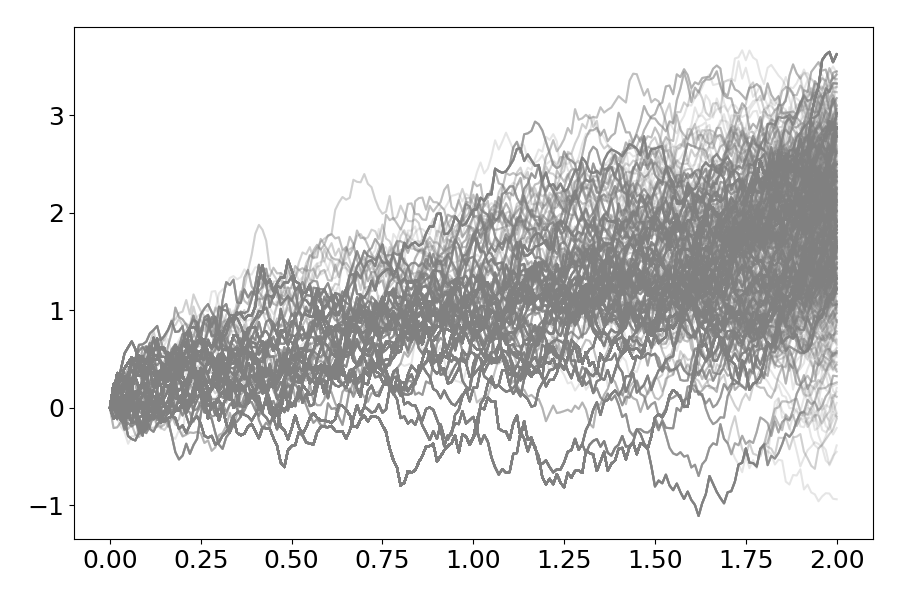

In [4]:
plt.close(1)
fig, ax = plt.subplots(num=1, figsize=(9,6))

for traj in rec_trajs.values():
    plt.plot(traj[:,0], traj[:,1], color='gray', alpha=0.2)

fig.tight_layout()

In [73]:
np.min(list(observables.values()))

1.0618594036131523

In [38]:
rec_dict['independent_parents']

[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 6, 9, 9, 12]

## Compute expectations

In [5]:
def f(x, a):
    return float(x > a)

def expectation(func, **kwargs):
    _f = np.array([func(x, **kwargs) for x in observables.values()])
    _w = np.array([r['weight'] for r in rec_dict['members'].values()])
    # _w = np.exp(-np.array([r['cum_log_escore'] for r in rec_dict['members'].values()]))
    # _n = np.exp(rec_dict['cum_log_norm_factor'])

    mean = np.mean(_f*_w)
    std = np.sqrt(np.mean(_f*_w**2)/len(_w))

    return unc.ufloat(mean,std)

In [66]:
expectation(f, a=2)

0.0007899251449317518+/-0.00015295848783156678

## Theoretical probability of overcoming threshold

In [21]:
lam = 1
sig = 1
def ou_var(t):
    return sig**2/(2*lam)*(1 - np.exp(-2*lam*t))

cum_gaus = lambda x: 0.5*(1 + ss.erf(x/np.sqrt(2)))

overcoming_prob = lambda x,v: cum_gaus(-x/np.sqrt(v))

In [23]:
t = rec_trajs['r001'][-1,0]
v = ou_var(t)

In [24]:
a = np.linspace(0,4,101)

e = np.array([expectation(f, a=_a) for _a in a])
e_th = overcoming_prob(a,v)

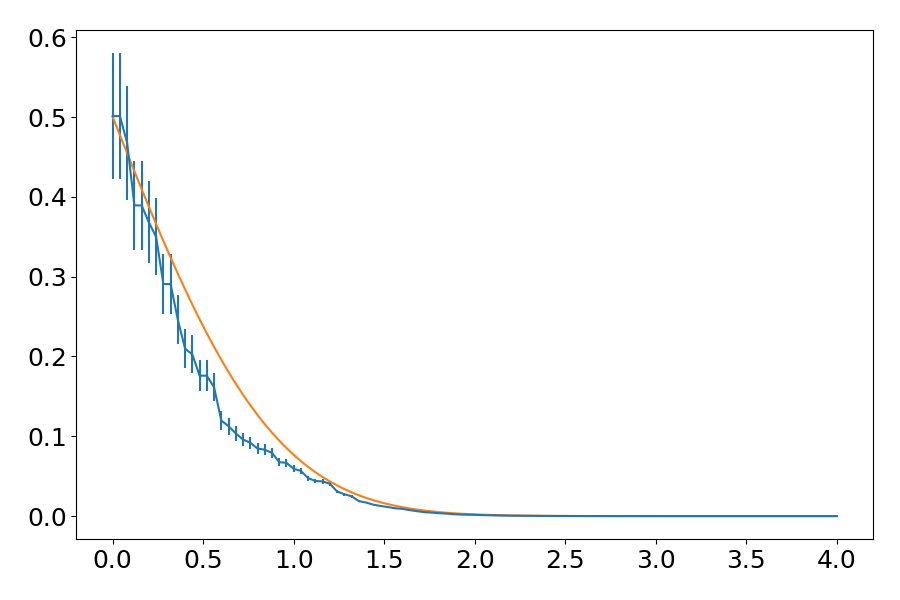

In [25]:
plt.close(2)
fig,ax = plt.subplots(figsize=(9,6))

uplt.plot(a,e)
plt.plot(a, e_th)
# plt.plot(a,uplt.std_dev(e)/uplt.nominal_value(e))

fig.tight_layout()

In [62]:
uplt.plot(a,e)
# plt.plot(a,uplt.std_dev(e)/uplt.nominal_value(e))

<ErrorbarContainer object of 3 artists>